# Predicting movie rental durations

![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

## Importing Libraries

In [267]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.tree import DecisionTreeRegressor


## Loading and inspecting data

In [268]:
# Load dataset
data = pd.read_csv('rental_info.csv')

# Display the first few rows
data.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [269]:
# Shape of the dataset
data.shape

(15861, 15)

In [270]:
# Info about data types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rental_date       15861 non-null  object 
 1   return_date       15861 non-null  object 
 2   amount            15861 non-null  float64
 3   release_year      15861 non-null  float64
 4   rental_rate       15861 non-null  float64
 5   length            15861 non-null  float64
 6   replacement_cost  15861 non-null  float64
 7   special_features  15861 non-null  object 
 8   NC-17             15861 non-null  int64  
 9   PG                15861 non-null  int64  
 10  PG-13             15861 non-null  int64  
 11  R                 15861 non-null  int64  
 12  amount_2          15861 non-null  float64
 13  length_2          15861 non-null  float64
 14  rental_rate_2     15861 non-null  float64
dtypes: float64(8), int64(4), object(3)
memory usage: 1.8+ MB


In [271]:
# Summary statistics of numerical columns
data.describe()

,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
count,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000,15861.000000
mean,4.217161,2006.885379,2.944101,114.994578,20.224727,0.204842,0.200303,0.223378,0.198726,23.355504,14832.841876,11.389287
std,2.360383,2.025027,1.649766,40.114715,6.083784,0.403599,0.400239,0.416523,0.399054,23.503164,9393.431996,10.005293
min,0.990000,2004.000000,0.990000,46.000000,9.990000,0.000000,0.000000,0.000000,0.000000,0.980100,2116.000000,0.980100
25%,2.990000,2005.000000,0.990000,81.000000,14.990000,0.000000,0.000000,0.000000,0.000000,8.940100,6561.000000,0.980100
50%,3.990000,2007.000000,2.990000,114.000000,20.990000,0.000000,0.000000,0.000000,0.000000,15.920100,12996.000000,8.940100
75%,4.990000,2009.000000,4.990000,148.000000,25.990000,0.000000,0.000000,0.000000,0.000000,24.900100,21904.000000,24.900100
max,11.990000,2010.000000,4.990000,185.000000,29.990000,1.000000,1.000000,1.000000,1.000000,143.760100,34225.000000,24.900100


## Exploratory Data Analysis (EDA)

In [272]:
# Count of unique values in 'special_features' column
data['special_features'].value_counts()


{Trailers,Commentaries,"Behind the Scenes"}                     1308
{Trailers}                                                      1139
{Trailers,Commentaries}                                         1129
{Trailers,"Behind the Scenes"}                                  1122
{"Behind the Scenes"}                                           1108
{Commentaries,"Deleted Scenes","Behind the Scenes"}             1101
{Commentaries}                                                  1089
{Commentaries,"Behind the Scenes"}                              1078
{Trailers,"Deleted Scenes"}                                     1047
{"Deleted Scenes","Behind the Scenes"}                          1035
{"Deleted Scenes"}                                              1023
{Commentaries,"Deleted Scenes"}                                 1011
{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}     983
{Trailers,Commentaries,"Deleted Scenes"}                         916
{Trailers,"Deleted Scenes","Behind

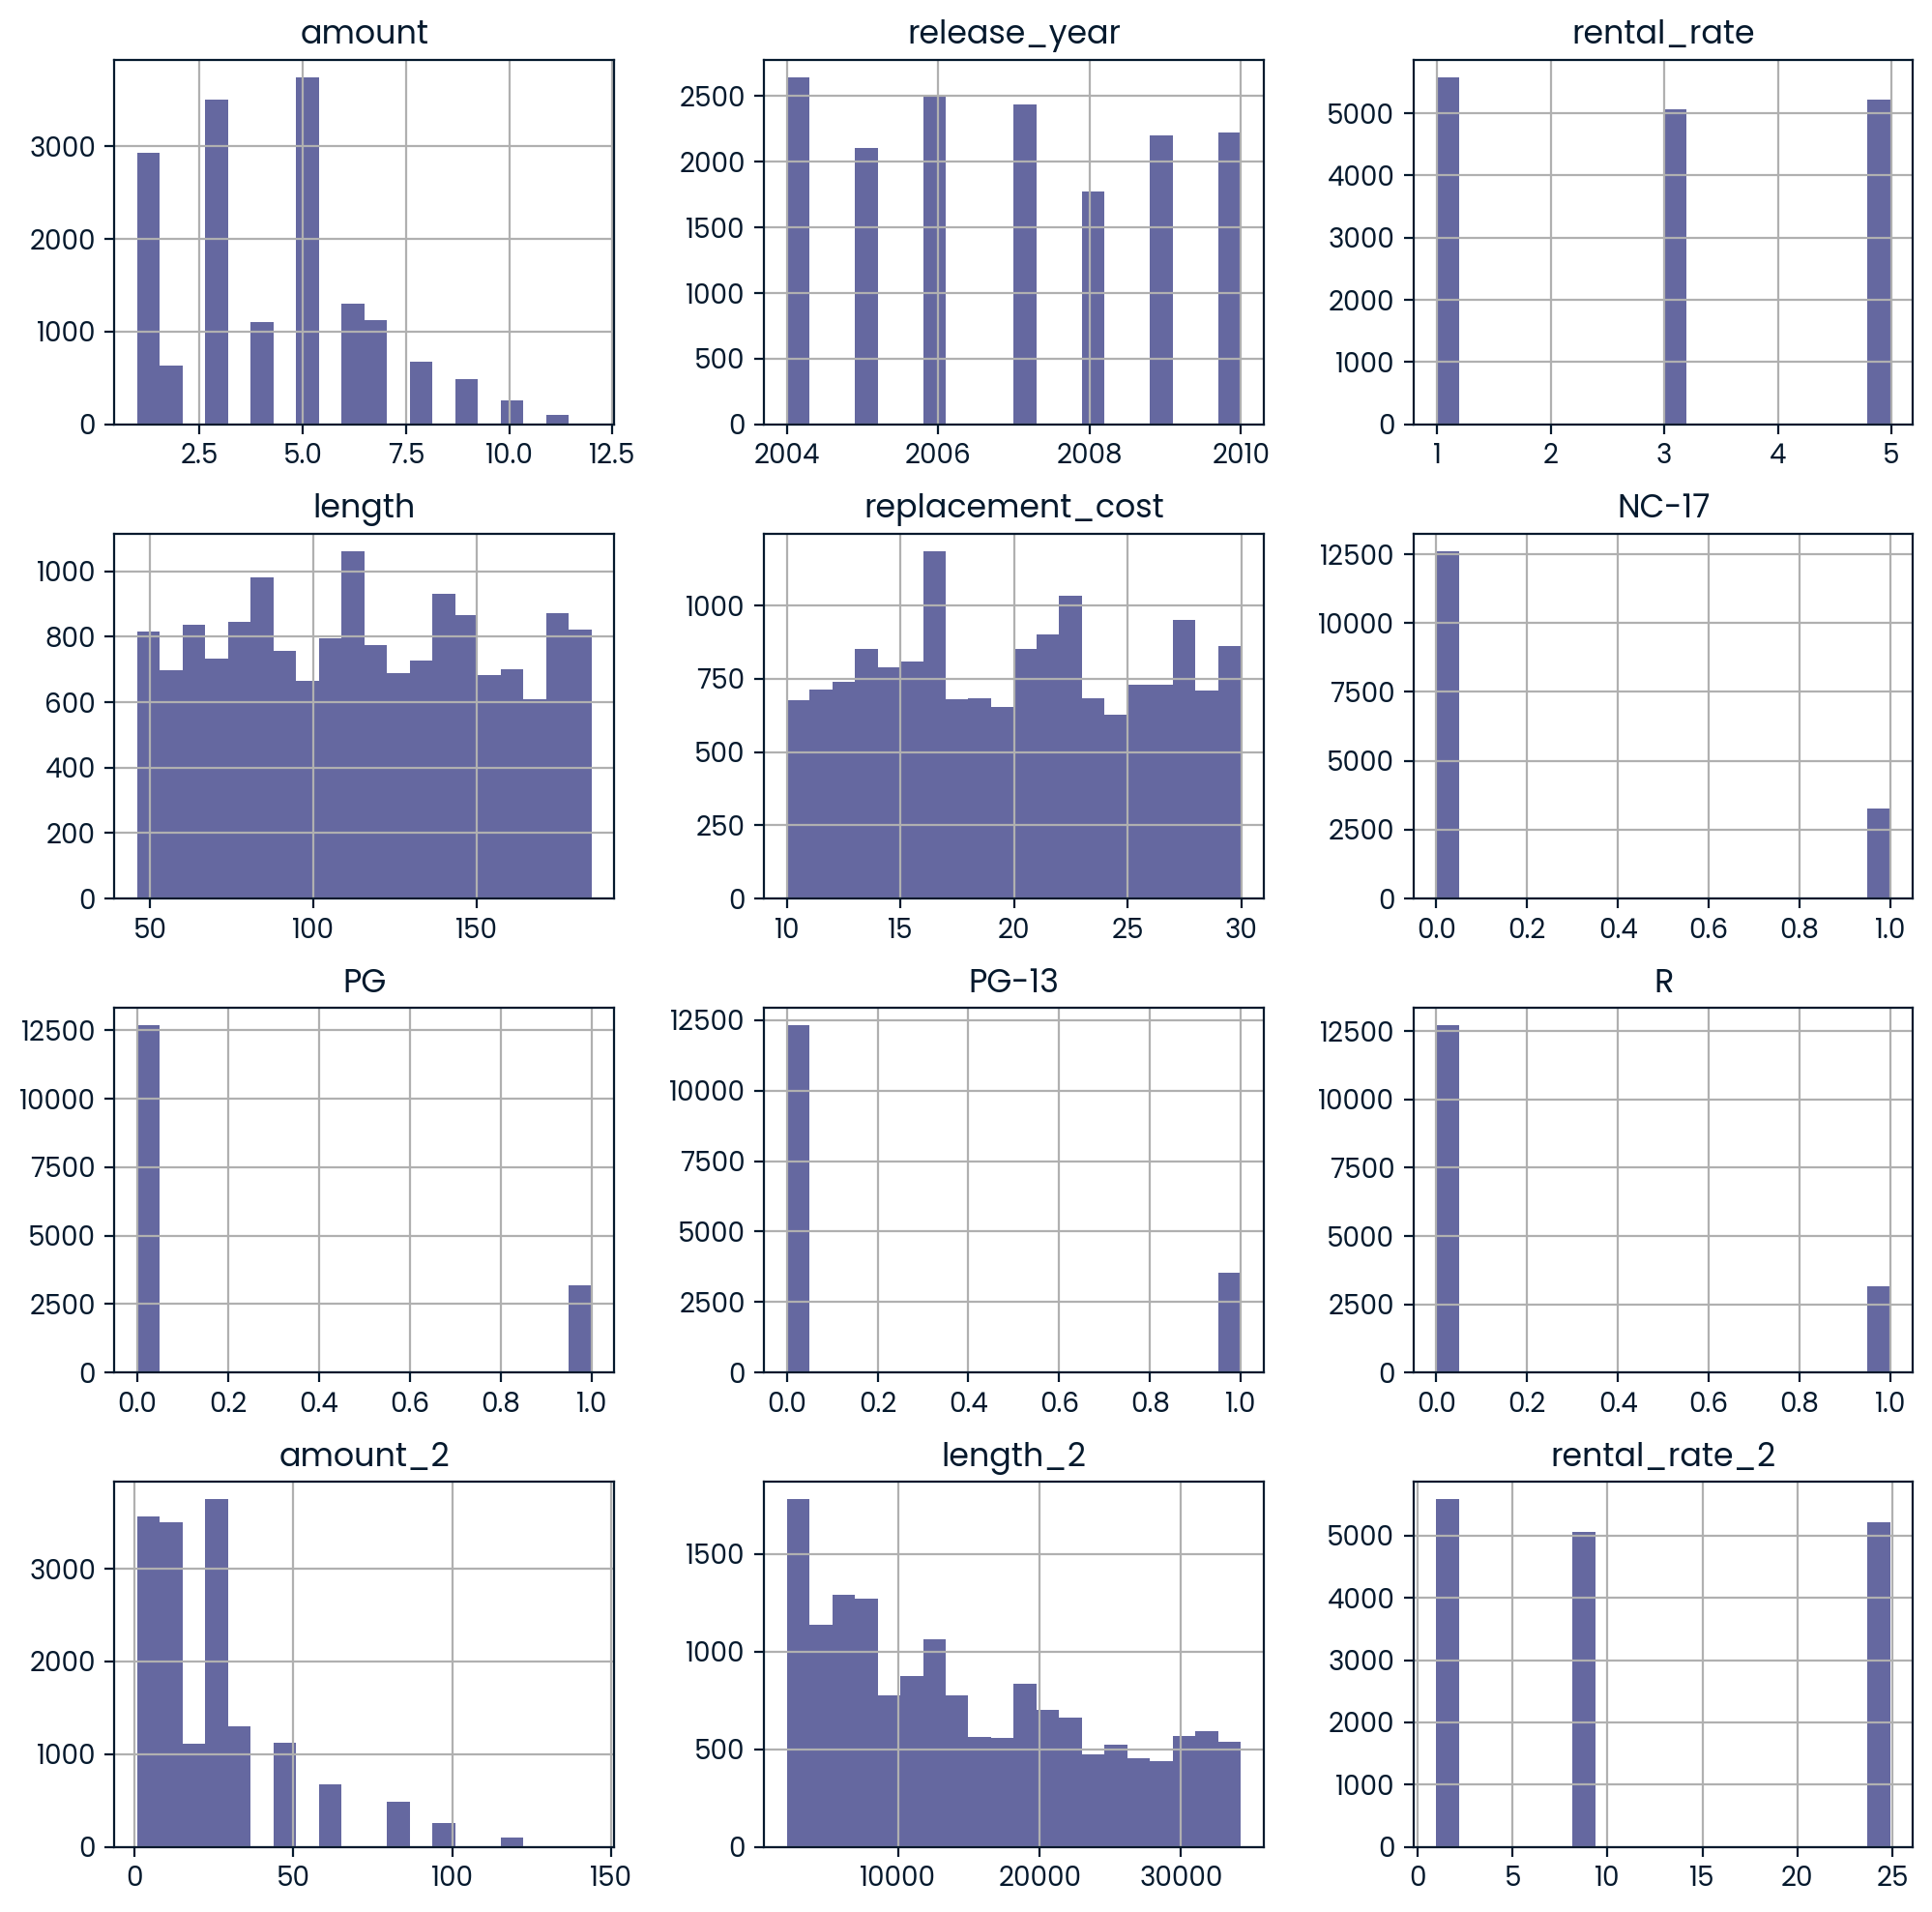

In [273]:
# Histograms of all numerical columns
data.hist(bins=20, figsize=(12,12))
plt.show()


In [274]:
# Checking for missing values
data.isna().sum()


rental_date         0
return_date         0
amount              0
release_year        0
rental_rate         0
length              0
replacement_cost    0
special_features    0
NC-17               0
PG                  0
PG-13               0
R                   0
amount_2            0
length_2            0
rental_rate_2       0
dtype: int64

In [275]:
# Correlation matrix to observe relationships between variables
data.corr()


,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
amount,1.000000,0.021726,0.685870,0.018947,-0.026725,0.003968,-0.010591,0.012773,-0.007029,0.956141,0.017864,0.678597
release_year,0.021726,1.000000,0.037304,0.031088,0.069991,0.027187,-0.022237,0.027442,-0.052645,0.015941,0.030640,0.025106
rental_rate,0.685870,0.037304,1.000000,0.055224,-0.064787,0.036280,0.000174,0.022812,-0.033648,0.587627,0.053390,0.982489
length,0.018947,0.031088,0.055224,1.000000,0.026976,-0.030133,-0.049304,0.057023,0.068685,0.015765,0.987667,0.051516
replacement_cost,-0.026725,0.069991,-0.064787,0.026976,1.000000,-0.001685,-0.077158,0.044224,0.017768,-0.018281,0.029747,-0.065835
NC-17,0.003968,0.027187,0.036280,-0.030133,-0.001685,1.000000,-0.254017,-0.272206,-0.252767,0.001186,-0.029444,0.038815
PG,-0.010591,-0.022237,0.000174,-0.049304,-0.077158,-0.254017,1.000000,-0.268408,-0.249240,-0.012859,-0.053299,-0.001420
PG-13,0.012773,0.027442,0.022812,0.057023,0.044224,-0.272206,-0.268408,1.000000,-0.267087,0.008954,0.062629,0.022525
R,-0.007029,-0.052645,-0.033648,0.068685,0.017768,-0.252767,-0.249240,-0.267087,1.000000,-0.004797,0.059310,-0.033067
amount_2,0.956141,0.015941,0.587627,0.015765,-0.018281,0.001186,-0.012859,0.008954,-0.004797,1.000000,0.014662,0.596622


In [256]:
# Scatter matrix for numerical columns to observe distributions and correlations
scatter_matrix(data, figsize=(25,20))
plt.show()


## Feature engineering

In [257]:
# Convert 'rental_date' and 'return_date' columns to datetime
data['rental_date'] = pd.to_datetime(data['rental_date'])
data['return_date'] = pd.to_datetime(data['return_date'])

# Create a new column for rental duration in days
data['rental_length_days'] = (data['return_date'] - data['rental_date']).dt.days

# Inspect the new column
data[['rental_date', 'return_date', 'rental_length_days']].head()


,rental_date,return_date,rental_length_days
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,3
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,7
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,4


## Creating dummy variables

In [258]:
# Create binary variables for 'Deleted Scenes' and 'Behind the Scenes' features
data['deleted_scenes'] = data['special_features'].str.contains('Deleted Scenes').astype(int)
data['behind_the_scenes'] = data['special_features'].str.contains('Behind the Scenes').astype(int)

# Sample 10 rows to check the new columns
data.sample(10)


,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,rental_length_days,deleted_scenes,behind_the_scenes
4730,2005-07-31 01:56:13+00:00,2005-08-04 22:03:13+00:00,2.99,2010.0,0.99,98.0,22.99,"{""Behind the Scenes""}",0,0,0,1,8.9401,9604.0,0.9801,4,0,1
1172,2005-05-27 18:11:22+00:00,2005-06-03 00:06:22+00:00,3.99,2004.0,0.99,108.0,13.99,"{Trailers,Commentaries,""Deleted Scenes"",""Behin...",0,0,0,0,15.9201,11664.0,0.9801,6,1,1
3749,2005-08-21 13:16:19+00:00,2005-08-22 13:28:19+00:00,0.99,2004.0,0.99,168.0,10.99,"{Commentaries,""Deleted Scenes"",""Behind the Sce...",1,0,0,0,0.9801,28224.0,0.9801,1,1,1
13761,2005-07-30 10:35:21+00:00,2005-07-31 14:27:21+00:00,0.99,2005.0,0.99,138.0,20.99,"{Commentaries,""Behind the Scenes""}",0,0,1,0,0.9801,19044.0,0.9801,1,0,1
10485,2005-07-09 11:25:54+00:00,2005-07-16 08:04:54+00:00,1.99,2008.0,0.99,169.0,12.99,"{""Behind the Scenes""}",0,0,0,1,3.9601,28561.0,0.9801,6,0,1
5235,2005-08-01 18:25:40+00:00,2005-08-10 13:07:40+00:00,10.99,2009.0,4.99,149.0,25.99,"{Trailers,""Deleted Scenes"",""Behind the Scenes""}",0,1,0,0,120.7801,22201.0,24.9001,8,1,1
1525,2005-05-25 16:17:46+00:00,2005-06-01 14:48:46+00:00,6.99,2006.0,2.99,130.0,28.99,"{""Deleted Scenes""}",0,0,0,0,48.8601,16900.0,8.9401,6,1,0
2523,2005-07-29 02:52:58+00:00,2005-08-04 06:12:58+00:00,5.99,2007.0,2.99,47.0,22.99,{Trailers},0,1,0,0,35.8801,2209.0,8.9401,6,0,0
3032,2005-06-15 21:31:57+00:00,2005-06-17 02:22:57+00:00,2.99,2006.0,2.99,48.0,19.99,{Commentaries},0,1,0,0,8.9401,2304.0,8.9401,1,0,0
11005,2005-07-31 16:46:52+00:00,2005-08-04 14:52:52+00:00,4.99,2010.0,4.99,80.0,28.99,{Trailers},0,0,1,0,24.9001,6400.0,24.9001,3,0,0


## Selecting Features for the Model

In [259]:
# Defining the input features
required_columns = ['amount', 'release_year', 'rental_rate', 'length', 
                    'replacement_cost', 'NC-17', 'PG', 'PG-13', 'R', 
                    'amount_2', 'length_2', 'rental_rate_2', 
                    'deleted_scenes', 'behind_the_scenes']

# Selecting the input features (X) and target variable (y)
X = data[required_columns]
y = data['rental_length_days']

# Display a sample of the selected features
X.sample(10)


,amount,release_year,rental_rate,length,replacement_cost,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2,deleted_scenes,behind_the_scenes
4747,4.99,2004.0,4.99,75.0,12.99,0,1,0,0,24.9001,5625.0,24.9001,1,1
994,3.99,2006.0,0.99,173.0,9.99,0,1,0,0,15.9201,29929.0,0.9801,1,1
6782,5.99,2005.0,4.99,177.0,20.99,1,0,0,0,35.8801,31329.0,24.9001,1,1
12452,3.99,2009.0,2.99,168.0,11.99,1,0,0,0,15.9201,28224.0,8.9401,1,0
5230,4.99,2009.0,4.99,149.0,25.99,0,1,0,0,24.9001,22201.0,24.9001,1,1
1908,2.99,2008.0,2.99,161.0,26.99,0,0,1,0,8.9401,25921.0,8.9401,1,0
483,4.99,2005.0,4.99,135.0,28.99,0,0,1,0,24.9001,18225.0,24.9001,1,1
9512,2.99,2010.0,2.99,92.0,19.99,1,0,0,0,8.9401,8464.0,8.9401,0,0
3629,5.99,2010.0,2.99,170.0,15.99,0,0,0,0,35.8801,28900.0,8.9401,0,1
10052,0.99,2010.0,0.99,78.0,26.99,1,0,0,0,0.9801,6084.0,0.9801,1,0


 ## Exploring the Selected Features

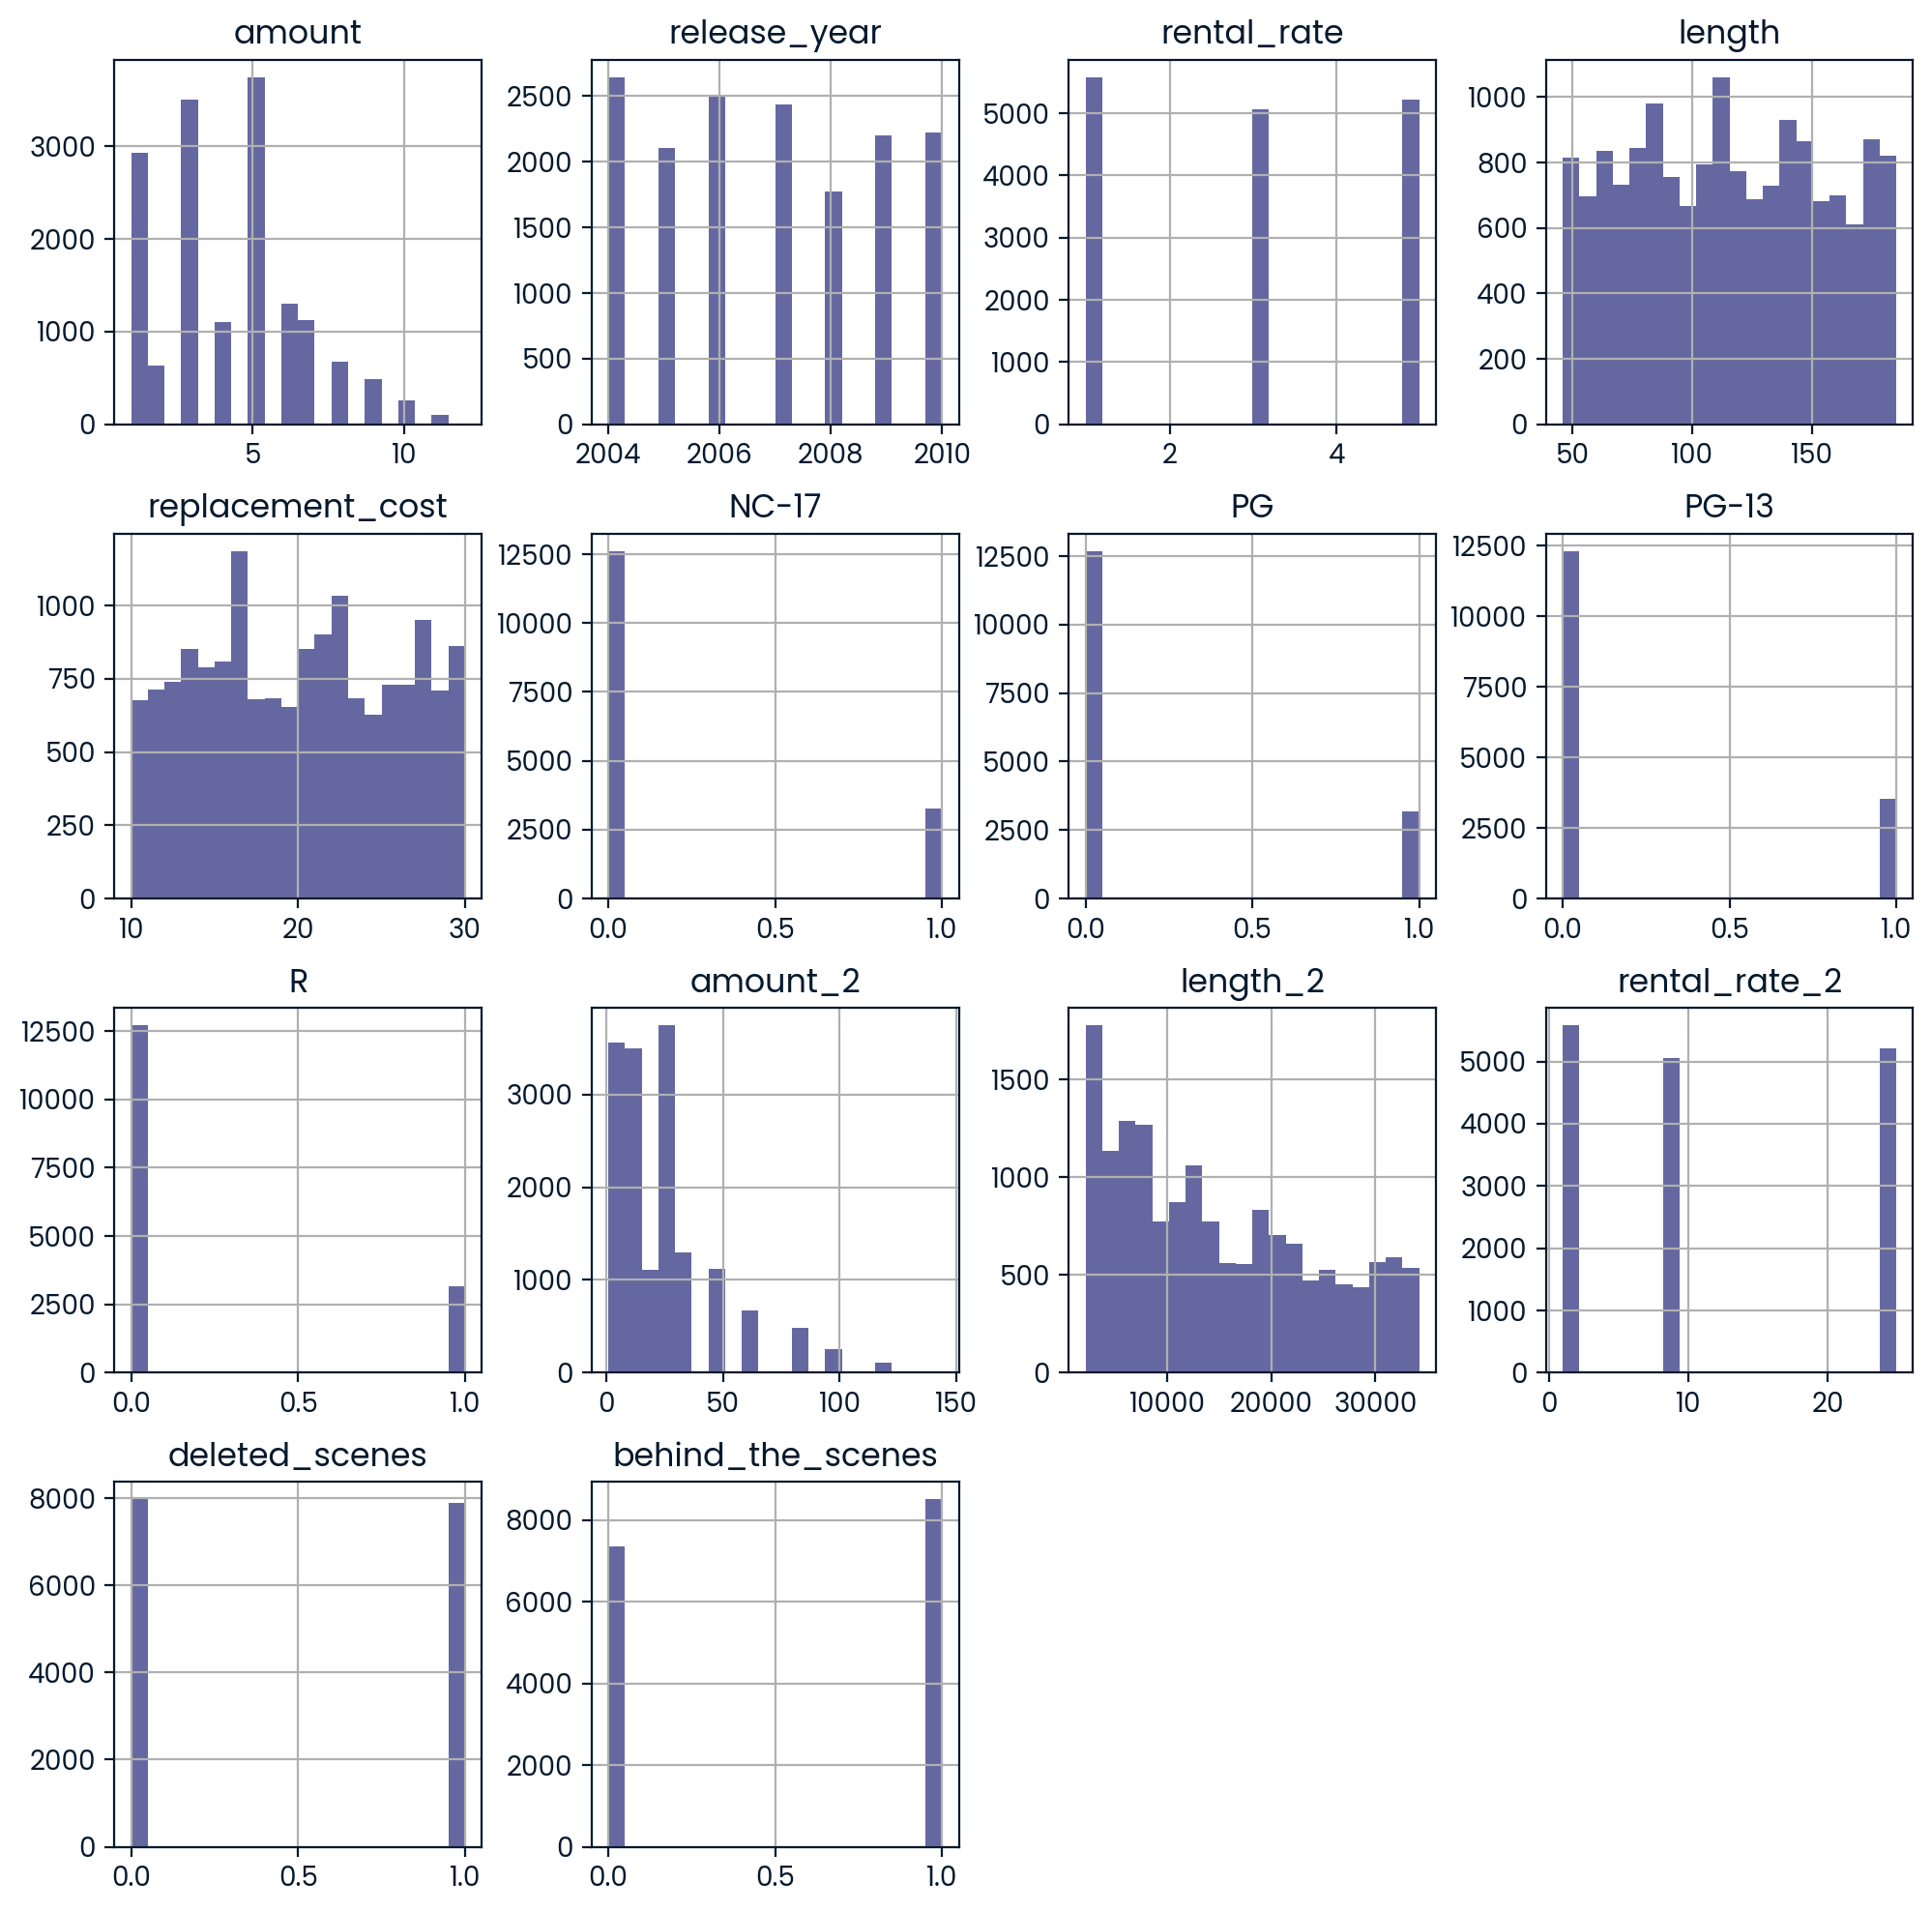

In [260]:
# Histogram of input features
X.hist(bins=20, figsize=(12,12))
plt.show()



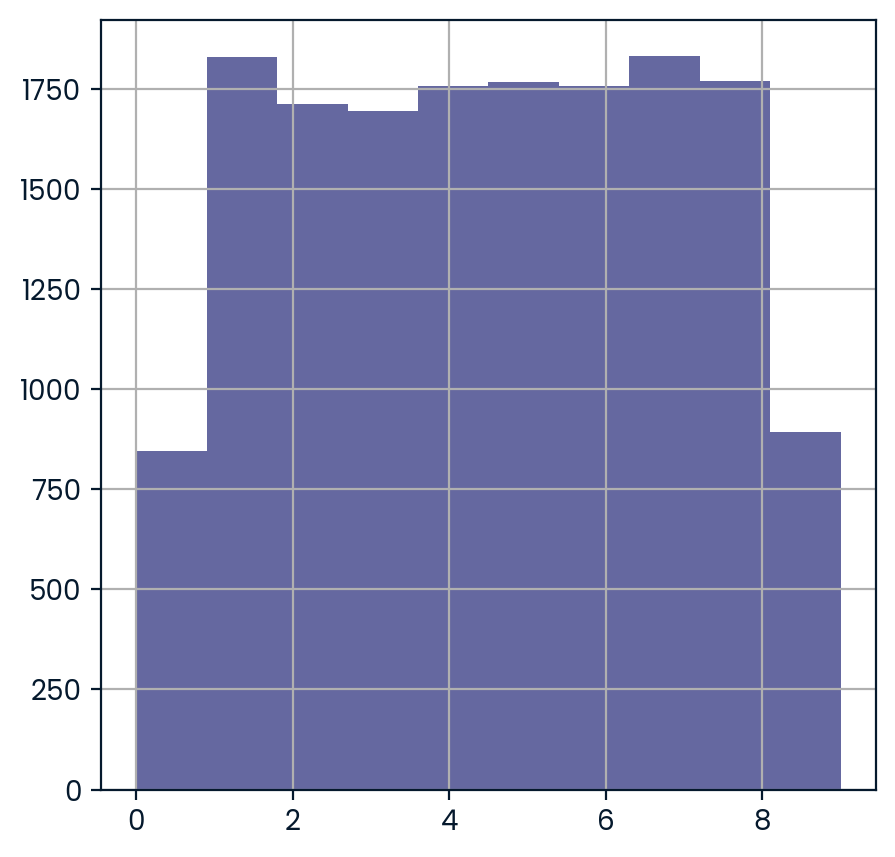

In [261]:
# Histogram of the target variable (rental length in days)
y.hist(bins=10, figsize=(5,5))
plt.show()


In [262]:
# Count of unique values in the target variable
y.value_counts()


7    1832
1    1829
8    1771
5    1767
6    1758
4    1757
2    1713
3    1694
9     894
0     846
Name: rental_length_days, dtype: int64

## Train-Test Split

In [263]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

# Displaying the shapes of the split datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(12688, 14)
(12688,)
(3173, 14)
(3173,)


## Training the Decision Tree Regressor

In [264]:
# Initialize the Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=9)

# Train the model
tree_reg.fit(X_train, y_train)


DecisionTreeRegressor(random_state=9)

## Making Predictions and Evaluating the Model

In [265]:
# Making predictions on the test set
predictions = tree_reg.predict(X_test)

# Calculating the Root Mean Squared Error (RMSE)
tree_mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', tree_mse)


Mean Squared Error: 2.1675004952579413


## Storing the Best Model


In [266]:
# Storing the best model and its performance metric
best_model = tree_reg
best_mse = tree_rmse


This notebook demonstrates a regression approach to predict DVD rental length in days. It includes data preprocessing, exploratory analysis, feature engineering, model training, and evaluation. The Decision Tree Regressor was used, and model performance was measured using RMSE.